In [1]:
import torch
print(torch.distributed.is_available())        
print(torch.distributed.is_gloo_available())   

True
True


In [8]:
%%writefile distributed_linear_fit_with_profiling.py
import os
import torch
import torch.distributed as dist
import torch.multiprocessing as mp
from datetime import timedelta
import time
import psutil
import torch.profiler

def setup(rank, world_size):
    os.environ["MASTER_ADDR"] = "localhost"
    os.environ["MASTER_PORT"] = "12355"
    dist.init_process_group("gloo", rank=rank, world_size=world_size, timeout=timedelta(seconds=9000))

def cleanup():
    if dist.is_initialized():
        dist.destroy_process_group()

def train(rank, world_size, X_full, y_full, epochs=10000, lr=0.01, momentum=0.9):
    setup(rank, world_size)
    
    # Split data among processes
    N = X_full.shape[0]
    local_n = N // world_size
    start = rank * local_n
    end = start + local_n if rank != world_size - 1 else N
    X = X_full[start:end]
    y = y_full[start:end]

    # Initialize weights
    torch.manual_seed(0)
    if rank == 0:
        w = torch.randn(2, 1, requires_grad=True)
        b = torch.randn(1, requires_grad=True)
    else:
        w = torch.zeros(2, 1, requires_grad=True)
        b = torch.zeros(1, requires_grad=True)
    
    dist.broadcast(w, src=0)
    dist.broadcast(b, src=0)

    v_w = torch.zeros_like(w)
    v_b = torch.zeros_like(b)
    converged = torch.tensor([0], dtype=torch.int32)
    losses = []
    comm_times = []  # Track communication time
    cpu_usages = []  # Track CPU usage

    # Initialize profiler
    profiler = torch.profiler.profile(
        activities=[torch.profiler.ProfilerActivity.CPU],
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=1),
        on_trace_ready=torch.profiler.tensorboard_trace_handler(f"profiler_rank_{rank}"),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
    )

    process = psutil.Process()  # For CPU usage
    profiler.start()
    
    try:
        for epoch in range(epochs):
            # Forward pass
            y_hat = X @ w + b
            loss = ((y_hat - y) ** 2).mean()
            losses.append(loss.item())

            # Backward pass
            loss.backward()
            
            # Synchronize gradients with timing
            with torch.no_grad():
                grad_w = w.grad.detach().clone()
                grad_b = b.grad.detach().clone()

                start_time = time.time()
                dist.all_reduce(grad_w, op=dist.ReduceOp.SUM)
                dist.all_reduce(grad_b, op=dist.ReduceOp.SUM)
                comm_time = time.time() - start_time
                comm_times.append(comm_time)

                grad_w /= world_size
                grad_b /= world_size

                v_w = momentum * v_w + (1 - momentum) * grad_w
                v_b = momentum * v_b + (1 - momentum) * grad_b
                w -= lr * v_w
                b -= lr * v_b
                w.grad.zero_()
                b.grad.zero_()

            # CPU usage
            cpu_usage = process.cpu_percent(interval=None)
            cpu_usages.append(cpu_usage)

            # Profiler step
            profiler.step()

            if loss.item() < 1e-3:
                converged[0] = 1
                print(f"Process {rank} converged at epoch {epoch+1}, Loss: {loss.item():.6f}")
            
            dist.all_reduce(converged, op=dist.ReduceOp.SUM)
            if converged.item() == world_size:
                print(f"Process {rank} exiting as all processes converged.")
                break

            if epoch % 100 == 0:
                print(f"Process {rank}, Epoch {epoch+1}, Loss: {loss.item():.6f}, "
                      f"Comm Time: {comm_time:.6f}s, CPU Usage: {cpu_usage:.2f}%")

        # Save losses, model, and stats
        torch.save(losses, f"losses_rank_{rank}.pt")
        torch.save({"w": w, "b": b}, f"model_rank_{rank}.pt")
        torch.save({"comm_times": comm_times, "cpu_usages": cpu_usages}, f"stats_rank_{rank}.pt")

    except RuntimeError as e:
        print(f"Process {rank} encountered error: {e}")
        raise
    finally:
        profiler.stop()
        cleanup()

def main():
    world_size = 10
    print(f"Using {world_size} processes")
    # Generate data
    N = 200
    torch.manual_seed(0)
    x1 = torch.linspace(-5, 5, N)
    x2 = torch.randn(N) * 2
    X = torch.stack((x1, x2), dim=1)
    X = (X - X.mean(dim=0)) / X.std(dim=0)  # Normalize
    true_w = torch.tensor([[2.0], [-3.0]])
    bias = 5.0
    y = X @ true_w + bias + torch.randn(N, 1) * 0.01

    mp.spawn(train, args=(world_size, X, y), nprocs=world_size, join=True)

if __name__ == "__main__":
    main()

Writing distributed_linear_fit_with_profiling.py


In [13]:
# !python3 distributed_linear_fit.py
!python3 distributed_linear_fit_with_profiling.py


Using 10 processes
Process 0, Epoch 1, Loss: 54.844379, Comm Time: 0.022995s, CPU Usage: 0.00%
Process 9, Epoch 1, Loss: 82.353706, Comm Time: 0.020832s, CPU Usage: 0.00%
Process 8, Epoch 1, Loss: 67.473038, Comm Time: 0.021245s, CPU Usage: 0.00%
Process 7, Epoch 1, Loss: 63.366131, Comm Time: 0.023064s, CPU Usage: 0.00%
Process 6, Epoch 1, Loss: 55.614510, Comm Time: 0.003901s, CPU Usage: 0.00%
Process 5, Epoch 1, Loss: 72.083130, Comm Time: 0.021941s, CPU Usage: 0.00%
Process 4, Epoch 1, Loss: 53.943718, Comm Time: 0.023725s, CPU Usage: 0.00%
Process 3, Epoch 1, Loss: 58.354225, Comm Time: 0.023904s, CPU Usage: 0.00%
Process 2, Epoch 1, Loss: 44.274029, Comm Time: 0.024065s, CPU Usage: 0.00%
Process 1, Epoch 1, Loss: 40.392403, Comm Time: 0.024502s, CPU Usage: 0.00%
STAGE:2025-08-01 05:39:43 251634:251634 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2025-08-01 05:39:43 251627:251627 ActivityProfilerController.cpp:311] Completed Stage: Warm Up
STAGE:2025-08-01 05

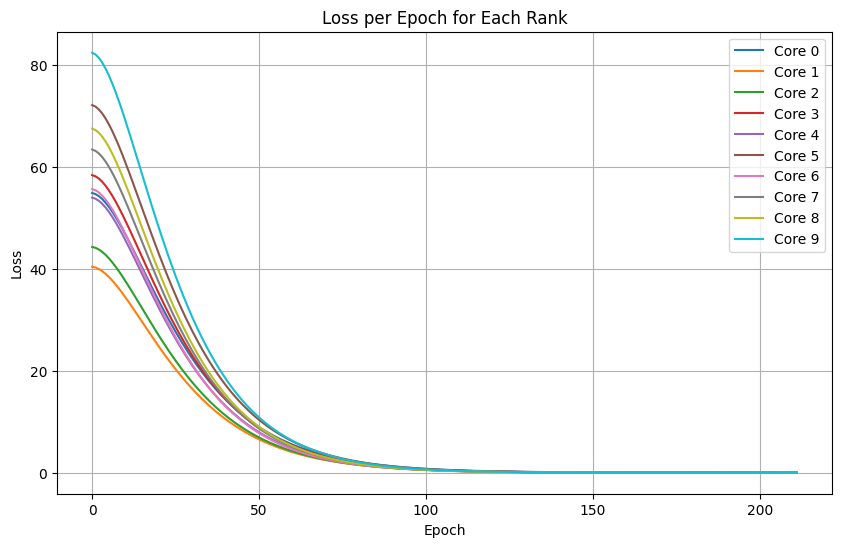

In [14]:
#load the loss pt fiels and plot them
import torch
import matplotlib.pyplot as plt
losses = []
for rank in range(10):
    try:
        loss = torch.load(f"losses_rank_{rank}.pt")
        losses.append(loss)
    except FileNotFoundError:
        print(f"Loss file for rank {rank} not found.")
plt.figure(figsize=(10, 6))
for rank, loss in enumerate(losses):
    plt.plot(loss, label=f'Core {rank}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch for Each Rank')
plt.legend()
plt.grid()
plt.show()

Rank 0 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 1 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 2 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 3 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 4 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 5 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 6 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 7 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 8 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714
Rank 9 - Weights: [[2.0078530311584473], [-2.985177516937256]], Bias: 4.9632, MSE: 0.001714

Selected model from rank 0 with MSE: 0.001714
Final model - Weights: [[2.007853

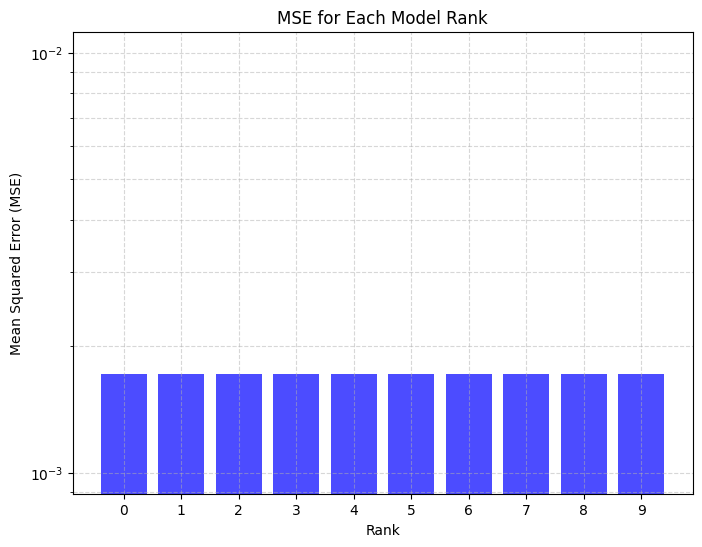

Final model MSE on test data: 0.001714


In [15]:
import torch
import matplotlib.pyplot as plt

# Generate test data (same as training)
N = 200
torch.manual_seed(0)
x1 = torch.linspace(-5, 5, N)
x2 = torch.randn(N) * 2  # Independent random values for x2
X = torch.stack((x1, x2), dim=1)  # shape (N, 2)

# Normalize input features (same as training)
X = (X - X.mean(dim=0)) / X.std(dim=0)

# Define true weights and bias
true_w = torch.tensor([[2.0], [-3.0]])  # shape (2, 1)
bias = 5.0
y = X @ true_w + bias + torch.randn(N, 1) * 0.01  # shape (N, 1)

# Load model parameters and compute MSE
mse_values = []
model_params = []
ranks = range(10)
for rank in ranks:
    try:
        params = torch.load(f"model_rank_{rank}.pt")
        w = params['w']
        b = params['b']
        # Compute predictions
        y_pred = X @ w + b
        mse = ((y_pred - y) ** 2).mean().item()
        model_params.append(params)
        mse_values.append(mse)
        print(f"Rank {rank} - Weights: {w.tolist()}, Bias: {b.item():.4f}, MSE: {mse:.6f}")
    except FileNotFoundError:
        print(f"Model file for rank {rank} not found.")
        model_params.append(None)
        mse_values.append(None)

# Select the final model (lowest MSE or rank 0 if all are similar)
valid_mses = [mse for mse in mse_values if mse is not None]
valid_ranks = [r for r, mse in zip(ranks, mse_values) if mse is not None]
if not valid_mses:
    raise ValueError("No valid model files found.")
best_rank = valid_ranks[valid_mses.index(min(valid_mses))]
final_params = model_params[best_rank]
print(f"\nSelected model from rank {best_rank} with MSE: {mse_values[best_rank]:.6f}")
print(f"Final model - Weights: {final_params['w'].tolist()}, Bias: {final_params['b'].item():.4f}")

# Save the final model
torch.save(final_params, "final_model.pt")

# Plot MSE for each rank
plt.figure(figsize=(8, 6))
plt.bar(valid_ranks, valid_mses, color='blue', alpha=0.7)
plt.xlabel('Rank')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('MSE for Each Model Rank')
plt.yscale('log')  # Log scale for small MSE values
plt.xticks(valid_ranks)
plt.grid(True, which="both", ls="--", alpha=0.5)
plt.show()

# Example: Use the final model for predictions
# Load final model
final_model = torch.load("final_model.pt")
w_final = final_model['w']
b_final = final_model['b']
# Predict on test data
y_pred_final = X @ w_final + b_final
final_mse = ((y_pred_final - y) ** 2).mean().item()
print(f"Final model MSE on test data: {final_mse:.6f}")

Rank 0: Avg Comm Time: 0.003574s, Avg CPU Usage: 39.16%
Rank 1: Avg Comm Time: 0.003545s, Avg CPU Usage: 45.34%
Rank 2: Avg Comm Time: 0.003556s, Avg CPU Usage: 47.19%
Rank 3: Avg Comm Time: 0.003537s, Avg CPU Usage: 49.38%
Rank 4: Avg Comm Time: 0.003556s, Avg CPU Usage: 48.94%
Rank 5: Avg Comm Time: 0.003528s, Avg CPU Usage: 49.75%
Rank 6: Avg Comm Time: 0.003489s, Avg CPU Usage: 49.95%
Rank 7: Avg Comm Time: 0.003558s, Avg CPU Usage: 49.96%
Rank 8: Avg Comm Time: 0.003502s, Avg CPU Usage: 51.96%
Rank 9: Avg Comm Time: 0.003532s, Avg CPU Usage: 46.92%
Average Communication Time Across Ranks: 0.003538s
Max Communication Time Across Ranks: 0.024502s
Average CPU Usage Across Ranks: 47.86%
Max CPU Usage Across Ranks: 318.10%


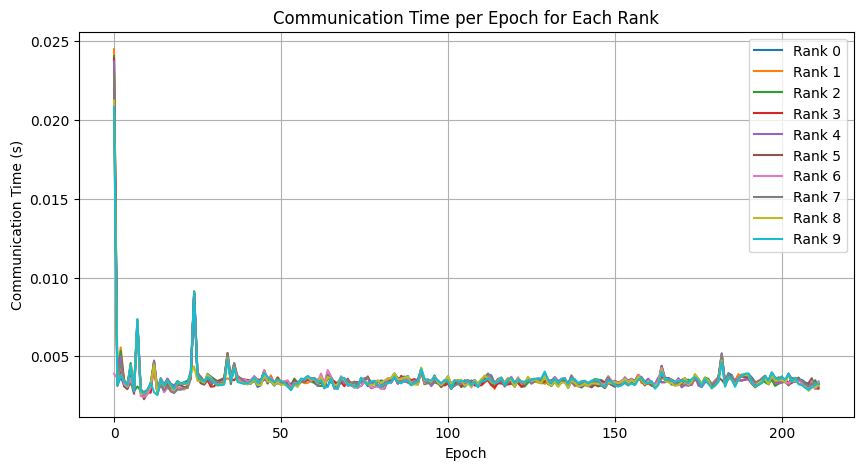

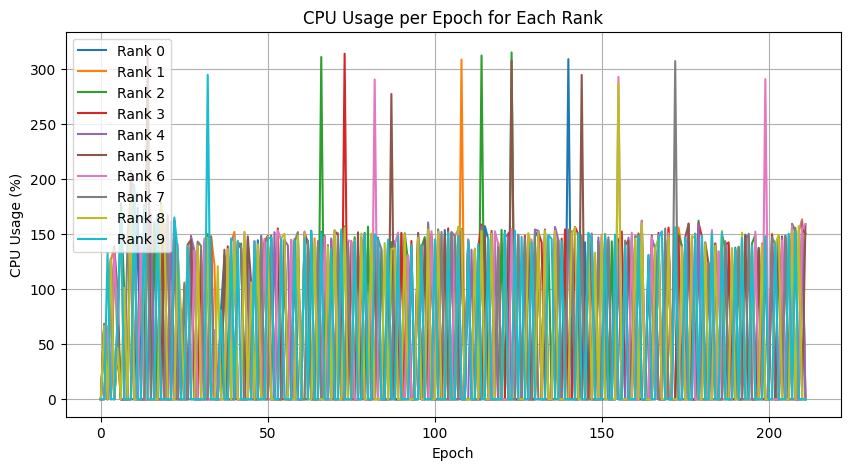

In [16]:
import torch
import matplotlib.pyplot as plt
import numpy as np

# Load stats for each rank
world_size = 10
comm_times_all = []
cpu_usages_all = []
for rank in range(world_size):
    try:
        stats = torch.load(f"stats_rank_{rank}.pt")
        comm_times_all.append(stats["comm_times"])
        cpu_usages_all.append(stats["cpu_usages"])
        print(f"Rank {rank}: Avg Comm Time: {np.mean(stats['comm_times']):.6f}s, "
              f"Avg CPU Usage: {np.mean(stats['cpu_usages']):.2f}%")
    except FileNotFoundError:
        print(f"Stats file for rank {rank} not found.")
        comm_times_all.append([])
        cpu_usages_all.append([])

# Compute aggregate stats
valid_comm_times = [ct for ct in comm_times_all if ct]
valid_cpu_usages = [cu for cu in cpu_usages_all if cu]
if valid_comm_times:
    avg_comm_times = np.mean([np.mean(ct) for ct in valid_comm_times])
    max_comm_times = np.max([np.max(ct) for ct in valid_comm_times])
    print(f"Average Communication Time Across Ranks: {avg_comm_times:.6f}s")
    print(f"Max Communication Time Across Ranks: {max_comm_times:.6f}s")
if valid_cpu_usages:
    avg_cpu_usage = np.mean([np.mean(cu) for cu in valid_cpu_usages])
    max_cpu_usage = np.max([np.max(cu) for cu in valid_cpu_usages])
    print(f"Average CPU Usage Across Ranks: {avg_cpu_usage:.2f}%")
    print(f"Max CPU Usage Across Ranks: {max_cpu_usage:.2f}%")

# Plot communication times
plt.figure(figsize=(10, 5))
for rank, comm_times in enumerate(comm_times_all):
    if comm_times:
        plt.plot(comm_times, label=f"Rank {rank}")
plt.xlabel("Epoch")
plt.ylabel("Communication Time (s)")
plt.title("Communication Time per Epoch for Each Rank")
plt.legend()
plt.grid(True)
plt.show()

# Plot CPU usage
plt.figure(figsize=(10, 5))
for rank, cpu_usages in enumerate(cpu_usages_all):
    if cpu_usages:
        plt.plot(cpu_usages, label=f"Rank {rank}")
plt.xlabel("Epoch")
plt.ylabel("CPU Usage (%)")
plt.title("CPU Usage per Epoch for Each Rank")
plt.legend()
plt.grid(True)
plt.show()